In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# CNN Example

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),      
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the images
])

dataset = datasets.ImageFolder(root="../Pre-processing/dataset/face_dataset/", transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
num_classes = len(dataset.classes)

C:\Users\46737\AppData\Local\Temp\ipykernel_17676\1661205742.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3679.)
  plt.imshow(dataset[0][0].T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


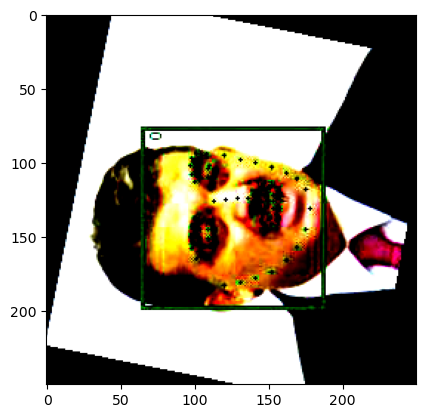

In [3]:
plt.imshow(dataset[0][0].T)

In [21]:
# images are (250, 250, 3)
# (((W - K + 2P)/S) + 1)
#         Here W = Input size
#         K = Filter size
#         S = Stride
#         P = Padding 

import torchvision.models as models

vgg16 = models.vgg16(pretrained=False)
vgg16.classifier[6] = nn.Linear(4096, num_classes)
vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001) 


/home/boman/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/boman/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


NameError: name 'device' is not defined

In [5]:
num_epochs = 30

for epoch in range(num_epochs):
    vgg16.train()  # Set the model to training mode
    
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        outputs = vgg16(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        
        loss.backward()  # Backward pass (calculate gradients)
        optimizer.step()  # Update weights
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    # Validate the model
    vgg16.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader.dataset)
    accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")


c:\Users\46737\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [1/30], Loss: 4.5397
Validation Loss: 4.4039, Accuracy: 0.1439
Epoch [2/30], Loss: 4.3759
Validation Loss: 4.2675, Accuracy: 0.1439
Epoch [3/30], Loss: 4.2258
Validation Loss: 4.1196, Accuracy: 0.1500
Epoch [4/30], Loss: 3.9896
Validation Loss: 3.9416, Accuracy: 0.1803
Epoch [5/30], Loss: 3.6312
Validation Loss: 3.4351, Accuracy: 0.2485
Epoch [6/30], Loss: 3.2064
Validation Loss: 3.1725, Accuracy: 0.2742
Epoch [7/30], Loss: 2.7462
Validation Loss: 2.7819, Accuracy: 0.3591
Epoch [8/30], Loss: 2.2924
Validation Loss: 2.5237, Accuracy: 0.3879
Epoch [9/30], Loss: 1.8297
Validation Loss: 2.2543, Accuracy: 0.4485
Epoch [10/30], Loss: 1.3982
Validation Loss: 2.2383, Accuracy: 0.4636
Epoch [11/30], Loss: 0.9429
Validation Loss: 2.3178, Accuracy: 0.5000
Epoch [12/30], Loss: 0.6398
Validation Loss: 2.3545, Accuracy: 0.5091
Epoch [13/30], Loss: 0.4268
Validation Loss: 2.3657, Accuracy: 0.5136
Epoch [14/30], Loss: 0.2938
Validation Loss: 2.7264, Accuracy: 0.5303
Epoch [15/30], Loss: 0.2193
V

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
data = pd.read_csv('../Pre-processing/dataset/anchor_points_dataset/gaussian_data_points.csv')

threshold = 50

value_counts = data['label'].value_counts()
data = data[data['label'].isin(value_counts[value_counts <= threshold].index)]
data = data[data['label'].isin(value_counts[value_counts > 20].index)]


X = data.drop(columns=['label']).to_numpy()
y = data['label'].to_numpy()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

input_size = X_train.shape[1]
num_classes = len(label_encoder.classes_)
print(data.info())
data['label'].value_counts()

label
Ricardo_Lagos             50
Hans_Blix                 49
Megawati_Sukarnoputri     48
Tom_Daschle               47
Mahmoud_Abbas             47
                          ..
James_Kelly               22
Sergio_Vieira_De_Mello    22
Harrison_Ford             21
Joe_Lieberman             21
Mike_Weir                 21
Name: count, Length: 72, dtype: int64

In [37]:
class ChenClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()

        hidden_size1 = int(input_size/1.5)
        hidden_size2 = int(input_size/2)
        hidden_size3 = int(input_size/4)

        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, num_classes)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x
    

model = ChenClassifier(input_size=input_size, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10000
batch_size = 100
 
for epoch in range(n_epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        Xbatch = X_train_tensor[i:i+batch_size]
        ybatch = y_train_tensor[i:i+batch_size]

        y_pred = model(Xbatch)
        loss = criterion(y_pred, ybatch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        _, val_pred = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_test_tensor.numpy(), val_pred.numpy())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

Epoch [10/10000], Loss: 3.1179, Val Accuracy: 2.66%
Epoch [20/10000], Loss: 2.7102, Val Accuracy: 2.66%
Epoch [30/10000], Loss: 2.5951, Val Accuracy: 3.10%
Epoch [40/10000], Loss: 2.3767, Val Accuracy: 2.66%
Epoch [50/10000], Loss: 2.1062, Val Accuracy: 2.88%
Epoch [60/10000], Loss: 1.9925, Val Accuracy: 2.44%
Epoch [70/10000], Loss: 1.6333, Val Accuracy: 3.10%
Epoch [80/10000], Loss: 1.5923, Val Accuracy: 3.55%
Epoch [90/10000], Loss: 1.0569, Val Accuracy: 3.55%
Epoch [100/10000], Loss: 1.0266, Val Accuracy: 4.88%
Epoch [110/10000], Loss: 0.9185, Val Accuracy: 4.43%
Epoch [120/10000], Loss: 0.7046, Val Accuracy: 3.99%
Epoch [130/10000], Loss: 0.7489, Val Accuracy: 3.99%
Epoch [140/10000], Loss: 0.5579, Val Accuracy: 4.88%
Epoch [150/10000], Loss: 0.5409, Val Accuracy: 4.66%
Epoch [160/10000], Loss: 0.4300, Val Accuracy: 5.10%
Epoch [170/10000], Loss: 0.4159, Val Accuracy: 5.10%
Epoch [180/10000], Loss: 0.2528, Val Accuracy: 4.88%
Epoch [190/10000], Loss: 0.2298, Val Accuracy: 5.32%
Ep

KeyboardInterrupt: 